# Distribution of values for channels and sensors

An interesting observation is how the values are distributed for the different channels and sensor if we ignore the temporal relationship. If these distributions are very different this is a hind that there is already some general structural difference which can likely be used for a classifyer. The reverse is not nessecarely true. Two very similar distributions ignoring the temporal relationship can still be very different when we put the timing back in.

In [1]:
%load_ext autoreload
%autoreload 2

In [385]:
import pickle
import gc
import tqdm
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import gestureanalysis.specific_utils as sutils
import gestureanalysis.generate_boxplots as gbo
from gestureanalysis.constants import Constants
from typing import List, Callable
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

In [3]:
base_path = "/home/jsimon/Documents/thesis/gesture-analysis/data/"
time_groups_path_corrected_pickl = base_path+"transformed/time_added/all/time-and-groups-corrected-all.pkl"
stats_added_path_pickl = base_path+"transformed/stats_added/all/raw_stats-added-all.pkl"

In [4]:
# check working directory and adopt if needed
import os
os.getcwd()

'/home/jsimon/Documents/thesis/gesture-analysis/scripts'

In [5]:
# in case you need to reload, and know it exists:
with open( time_groups_path_corrected_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

In [6]:
usernames = users.keys()
gestures = users['AB73']['label'][0]['data']['gesture'].unique()

## Enumerate all the channels

Let's see what channels we have. We have 63 channels with sensor data. The last columns from the dataset are a erroneous magnetometer in x,y,z and the labels. The other channels are somewhat mixed up. Generally the first channels are flex sensors with the exception of 1_Thumb_pressure which is a pressure sensor. The other pressure sensors are from 12_Finger_1_pressure to 15_Finger_4_pressure followed by two more flex sensors on the wrist. From that we always have triplets of an accelerometer x,y,z followed by a gyroscope x,y,z triplet for each of the IMUs on the glove. We finish with the magnetometer x,y,z.

In [7]:
cols = users['AB73']['glove_merged'].columns
cols

Index(['0_Thumb_base', '1_Thumb_pressure', '2_Angle_between_thumb_and_hand',
       '3_Finger_1_base', '4_Finger_1_tip', '5_Finger_2_base',
       '6_Finger_2_tip', '7_Finger_3_base', '8_Finger_3_tip',
       '9_Finger_4_base', '10_Finger_4_tip', '11_Thumb_tip',
       '12_Finger_1_pressure', '13_Finger_2_pressure', '14_Finger_3_pressure',
       '15_Finger_4_pressure', '16_Wrist_extension', '17_Wrist_flexion',
       '18_Finger_1_Accel_X', '19_Finger_1_Accel_Y', '20_Finger_1_Accel_Z',
       '21_Finger_1_Gyro_X', '22_Finger_1_Gyro_Y', '23_Finger_1_Gyro_Z',
       '24_Finger_2_Accel_X', '25_Finger_2_Accel_Y', '26_Finger_2_Accel_Z',
       '27_Finger_2_Gyro_X', '28_Finger_2_Gyro_Y', '29_Finger_2_Gyro_Z',
       '30_Finger_3_Accel_X', '31_Finger_3_Accel_Y', '32_Finger_3_Accel_Z',
       '33_Finger_3_Gyro_X', '34_Finger_3_Gyro_Y', '35_Finger_3_Gyro_Z',
       '36_Finger_4_Accel_X', '37_Finger_4_Accel_Y', '38_Finger_4_Accel_Z',
       '39_Finger_4_Gyro_X', '40_Finger_4_Gyro_Y', '41_Finger_

Since the channels are not too well structured I created a lookup dictionary with the indexes of the channels groups around some concepts. You find all the indices of the individual sensors in it, as you find anatomic concept like all the data of finger 1 or the thumb.

In [8]:
idx_keys = Constants().raw_indices.keys()
print(idx_keys)

dict_keys(['flex', 'pressure', 'accel', 'gyro', 'magnetometer', 'lin_accel', 'thumb', 'finger_1', 'finger_2', 'finger_3', 'finger_4', 'wrist', 'palm'])


## Explore the distribution for outliers

A classical thing is to explore the disbribution for outliers. In our case we assume outliers come from bad sensors. If that is true, tue to the distinctive nature of ouliers being seldom and good to detect, outliers bear the danger to be picked up as features for detecting certain gestures who just by chance happen to have outliers in them.

For detecting the outliers for a sensor the case is special. We have several million values for each sensor type. Often used methods like Local Outlier Factor (LOF) or Isolation Forrests can not cope with that amoudn of data. Although Isolation Forrests claim to have linear memory requirenments trough subsampling when building the trees, I could not get it running with a computer of 32 GB. I discarded the experiment with a 61GB machine on AWS after half an hour of running time. The LOF paper does not say anything on memory consumption. Actually, while the Isolation Forrest threw an pytho Memory Exception on the 32 GB machine, the LOF just did not terminate, and I ended the experiments after a few hours.

I therefor modified the exporation the following way:
- I use the LOF anomaly detection since we currently look into densities.
- I devide the data into batches of 500.000 random samples earch. I perform the LOF on these.
- I then count the number of outliers at the upper and lower 1,5% quantile.
- I then compute a fraction of outlies in the quantile vs. non outliers. If there are more than 0.5% outliers I assume the sensor has otliers in the area below the 1.5 upper and lower qnantile, else I declare the sensor outlier free.
- I then tune the lower and upper quartile to reach a level where LOF says about 2% are outliers. I set LOF to assume only 0.01 % of the data to be an outlier, so we will not get a result of f.e. more than 50%. I then tread all this data as outliers for the future.

With this information we can obtain the quality of each sensor in our experiment. The following table summarizes the results:

In [11]:
def get_all_values(columes):
    all_vals = sutils.collect_values(usernames, users, columes, False, 
                                     None, None, False, None, use_tqtm=True)
    return all_vals

In [206]:
def find_outliers_forres(X):
    clf = IsolationForest(max_samples=100, n_jobs=3)
    clf.fit(X)
    y_pred = clf.predict(X)
    return y_pred, None

def find_outliers_(X):
    clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1, n_jobs=3)
    y_pred = clf.fit_predict(X)
    X_scores = clf.negative_outlier_factor_
    return y_pred, X_scores

def visualise_outliers(X, y_pred, X_scores):
    print('num data: ', len(X))
    print('num outliers: ', len(y_pred[y_pred < 0]))
    print('y_pred < 0 shape: ', (y_pred < 0).shape)
    Xax = np.ones(len(X)) + np.random.uniform(-0.5, 0.5, len(X))
    X = X.reshape(len(X),)
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(x=Xax, y=X, color='k', s=0.01, label='Data points')
    # plot circles with radius proportional to the outlier scores
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    plt.scatter(Xax[y_pred < 0], X[y_pred < 0], edgecolors='r', linewidth=1,
                facecolors='none', label='Outlier scores')
    plt.axis('tight')
    plt.show()

def visualise_total_outliers_for_sensor_scatter(X, y_idx):
    print('num data: ', len(X))
    print('num outliers: ', len(y_idx))
    print('y_pred < 0 shape: ', y_idx.shape)
    Xax = np.ones(len(X)) + np.random.uniform(-0.5, 0.5, len(X))
    X = X.reshape(len(X),)
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(x=Xax, y=X, color='k', s=0.01, label='Data points')
    # plot circles with radius proportional to the outlier scores
    plt.scatter(Xax[y_idx], X[y_idx], edgecolors='r', linewidth=0.5, alpha=0.5,
                facecolors='none', label='Outlier scores')
    plt.axis('tight')
    plt.show()

def visualise_total_outliers_for_sensor_hexbin(X, y_idx):
    print('num data: ', len(X))
    print('num outliers: ', len(y_idx))
    print('y_pred < 0 shape: ', y_idx.shape)
    Xax = np.ones(len(X)) + np.random.uniform(-0.5, 0.5, len(X))
    X = X.reshape(len(X),)
    plt.title("Local Outlier Factor (LOF)")
    plt.hexbin(x=Xax, y=X, gridsize=50, cmap='inferno', label='Data points')
    # plot circles with radius proportional to the outlier scores
    plt.scatter(Xax[y_idx], X[y_idx], edgecolors='r', linewidth=1,
                facecolors='none', label='Outlier scores')
    plt.axis('tight')
    plt.show()

In [403]:
all_accel = Constants().raw_indices['accel']
all_flex = Constants().raw_indices['flex']['all']
all_gyro = Constants().raw_indices['gyro']
all_pressure = Constants().raw_indices['pressure']
all_magnetometer = Constants().raw_indices['magnetometer']
sensor_names = ['acceleromter', 'flexation', 'gyroscope', 'pressure', 'magnetometer']
all_types = [all_accel, all_flex, all_gyro, all_pressure, all_magnetometer]
thresholds = [(0.03, 99.98), (0.588948, 99.56215), (0.05, 99.95), (0.03, 99.95), (0.1, 99.9)]

investigating  acceleromter


skipping userAE30
ut 6678.0
lt -4836.0


num data:  61216575
num outliers:  689695
y_pred < 0 shape:  (689695,)


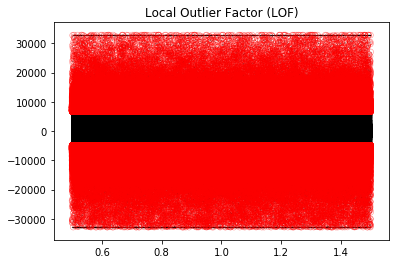

we found 56.3837% outliers in the outlier are
with this threshold we remove 1.99818% of data
investigating  flexation


skipping userAE30
ut 2615.433523014188
lt 561.7057004759554


num data:  37895975
num outliers:  11066
y_pred < 0 shape:  (11066,)


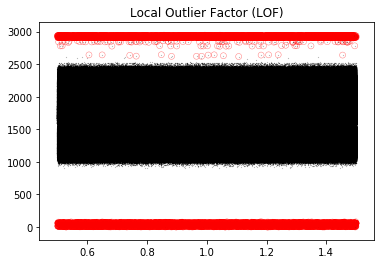

we found 2.84388% outliers in the outlier are
with this threshold we remove 1.0268% of data
investigating  gyroscope


skipping userAE30
ut 13348.0
lt -11547.0


num data:  61216575
num outliers:  41115
y_pred < 0 shape:  (41115,)


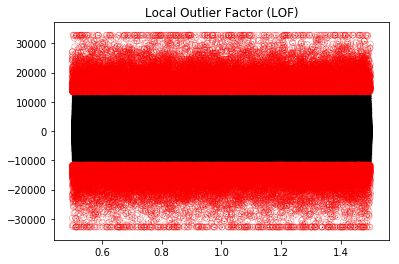

we found 67.1737% outliers in the outlier are
with this threshold we remove 0.0999844% of data
investigating  pressure


skipping userAE30
ut 3012.0
lt 340.0


num data:  14575375
num outliers:  3282
y_pred < 0 shape:  (3282,)


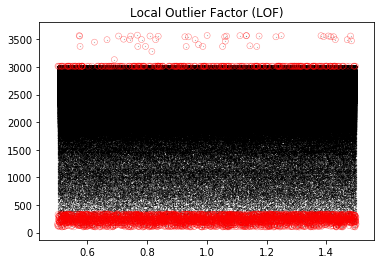

we found 42.1742% outliers in the outlier are
with this threshold we remove 0.0533914% of data


In [333]:
for tps,name,thrsh in tqdm.tqdm_notebook(zip(all_types, sensor_names, thresholds)):
    print('investigating ', name)
    X = get_all_values(cols[tps])
    X = np.array(X).reshape(-1, 1)
    lt, ut = thrsh
    upper_tresh = np.percentile(X, ut)
    lower_tresh = np.percentile(X, lt)
    print('ut', upper_tresh)
    print('lt', lower_tresh)
    found_outliers = []
    X_perm = np.random.permutation(len(X))
    X_perm = X[X_perm]
    for batch in tqdm.tqdm_notebook(range(0, len(X), 500000), leave=False):
        x = X_perm[batch:min(batch+500000, len(X))]
        y_pred, X_scores = find_outliers_(x)
        y_pred = remove_predictions_inside(x, y_pred, upper_tresh, lower_tresh)
        found_outliers += list(np.where(y_pred < 0)[0] + batch)
        gc.collect()
    visualise_total_outliers_for_sensor_scatter(X_perm, np.array(found_outliers))
    outside = len(X[X > upper_tresh]) + len(X[X < lower_tresh])
    outlier_factor = len(found_outliers)/outside
    print(f'we found {outlier_factor*100:g}% outliers in the outlier are')
    percent_removed = outside/len(X)
    print(f'with this threshold we remove {percent_removed*100:g}% of data')

## Manually tune one sensor
This part of the notebook does the same as above, just only for one manually set sensor type, and in individual cells. This is handy for tuning one specific sensor to find the threshold.

In [404]:
X = get_all_values(cols[all_magnetometer])

skipping userAE30


In [405]:
X = np.array(X).reshape(-1, 1)

In [406]:
def remove_predictions_inside(x, y_pred, upper_tresh, lower_tresh):
    y_candidate_idx = np.where(y_pred < 0)[0]
    x_candidate = x[y_candidate_idx].squeeze()
    x_upper = (x_candidate > upper_tresh)
    assert (x_candidate[x_upper] > upper_tresh).all()
    x_lower = (x_candidate < lower_tresh)
    assert (x_candidate[x_lower] < lower_tresh).all()
    x_outside = np.logical_or(x_upper, x_lower)
    x_inside = np.logical_not(x_outside)#.reshape(len(x_candidate),)
    #print('u', len(x_upper[x_upper==True]), 'l', len(x_lower[x_lower==True]), 
    #      'o', len(x_outside[x_outside==True]), 'i', len(x_inside[x_inside==True]))
    
    y_pred_wrong_idx = y_candidate_idx[x_inside]
    y_pred[y_pred_wrong_idx] = 1.
    assert ((x[y_pred < 0] < upper_tresh) | (x[y_pred < 0] > lower_tresh)).all()
    return y_pred

In [418]:
upper_tresh = np.percentile(X, 99.95)#99.95
lower_tresh = np.percentile(X, 0.03)#0.03
print('ut', upper_tresh)
print('lt', lower_tresh)

ut 620.0
lt -925.0


In [419]:
X_perm = np.random.permutation(len(X))
X_perm = X[X_perm]
y_preds = []
for batch in tqdm.tqdm_notebook(range(0, len(X), 500000)):
    x = X_perm[batch:min(batch+500000, len(X))]
    y_pred, X_scores = find_outliers_(x)
    y_preds.append(y_pred)

In [420]:
found_outliers = []
for batch in tqdm.tqdm_notebook(range(0, len(X), 500000)):
    x = X_perm[batch:min(batch+500000, len(X))]
    y_pred = y_preds[batch//500000]
    y_pred = remove_predictions_inside(x, y_pred, upper_tresh, lower_tresh)
    found_outliers += list(np.where(y_pred < 0)[0] + batch)
    #visualise_outliers(x, y_pred, X_scores)
    gc.collect()

num data:  8745225
num outliers:  4280
y_pred < 0 shape:  (4280,)


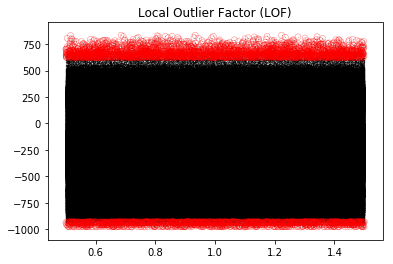

In [421]:
visualise_total_outliers_for_sensor_scatter(X_perm, np.array(found_outliers))

In [422]:
outside = len(X[X > upper_tresh]) + len(X[X < lower_tresh])
outlier_factor = len(found_outliers)/outside
print(f'we found {outlier_factor:g} outliers')

we found 0.622364 outliers


In [423]:
percent_removed = outside/len(X)
print(f'with this threshold we remove {percent_removed*100:g}% of data')

with this threshold we remove 0.0786372% of data


# Distribution Visualizations

The following section explores the different distributions visually. We first need to know if the values we look at are normal distributed, or if they are different. If they are normal distributed a boxplot gives a good inpression of the data distribution. If they are not we need a different visualization. We will test for that now:

In [380]:
usernames

dict_keys(['AB73', 'AE30', 'AF82', 'AL29', 'AW18', 'CB23', 'CB24', 'CF58', 'DG12', 'DH42', 'DL24', 'JL61', 'JQ28', 'JS52', 'MF20', 'MS55', 'PC29', 'PM32', 'PS42', 'RR45', 'RW32', 'SF1', 'YW13'])

In [388]:
data = {'user' : [],
        'sensor' : [],
        'N' : [],
        'min' : [],
        'max' : [],
        'k2' : [],
        'p' : []
       }

for sensor in sensor_names:
    sensor_idx = sensor_names.index(sensor)
    cs = cols[all_types[sensor_idx]]
    t = thresholds[sensor_idx]
    lower_percentile, higher_percentile = t
    vals = sutils.values_per_user_for_label_type_and_gesture(
        usernames, users, cs, 'manual', 'all_values', True, 
        higher_percentile, lower_percentile)
    for v, u in vals:
        vmin, vmax = v.min(), v.max()
        n = len(v)
        k2, p = sp.stats.normaltest(v)
        data['user'].append(u)
        data['sensor'].append(sensor)
        data['N'].append(n)
        data['min'].append(v.min())
        data['max'].append(v.max())
        data['k2'].append(k2)
        data['p'].append(p)
summary_df = pd.DataFrame(data)
summary_df

skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30


,user,sensor,N,min,max,k2,p
0,AB73,acceleromter,3843168,-2636,2518,8.444566e+05,0.0
1,AF82,acceleromter,2222535,-2439,2336,2.197433e+06,0.0
2,AL29,acceleromter,3869796,-2372,2497,6.599598e+06,0.0
3,AW18,acceleromter,2166339,-2787,2601,3.664112e+05,0.0
4,CB23,acceleromter,2211951,-2313,2566,1.668757e+05,0.0
5,CB24,acceleromter,2227722,-2367,2426,1.270681e+05,0.0
6,CF58,acceleromter,2505216,-2783,2513,8.868839e+05,0.0
7,DG12,acceleromter,2195571,-3074,2545,3.843390e+05,0.0
8,DH42,acceleromter,2319135,-2654,2451,1.001795e+06,0.0
9,DL24,acceleromter,3806838,-2614,2707,8.133829e+05,0.0


In [360]:
def describe_value_range(sensor_name, remove_outliers, show_overal):
    sensor_idx = sensor_names.index(sensor_name)
    cs = cols[all_types[sensor_idx]]
    t = thresholds[sensor_idx]
    lower_percentile, higher_percentile = t
    def describe_values(line, username):
        print('user: ', username)
        print(pd.DataFrame(data=line).describe())
        print("")
    all_vals = sutils.collect_values(usernames, users, cs, remove_outliers, 
                                     higher_percentile, lower_percentile, 
                                     True, describe_values, use_tqtm=True)
    if show_overal:
        print(pd.DataFrame(data=all_vals).describe())

In [374]:
def all_distributions_in_one_image(sensor_name):
    sensor_idx = sensor_names.index(sensor_name)
    cs = cols[all_types[sensor_idx]]
    t = thresholds[sensor_idx]
    lower_percentile, higher_percentile = t
    gbo.show_valuerange_boxplots_in_one_image(usernames, users, f'all {sensor_name} sensor channels', cs, 
                                        True, higher_percentile, lower_percentile, False, False)

## Accelerometer

The accelerometer has 61M values in our dataset...

In [373]:
describe_value_range('acceleromter', True, True)

user:  AB73
                  0
count  3.843168e+06
mean   4.239932e+02
std    1.117861e+03
min   -2.636000e+03
25%   -6.070000e+02
50%    6.750000e+02
75%    1.356000e+03
max    2.518000e+03

skipping userAE30
user:  AF82
                  0
count  2.222535e+06
mean   3.274677e+02
std    1.134288e+03
min   -2.439000e+03
25%   -7.190000e+02
50%    3.790000e+02
75%    1.435000e+03
max    2.336000e+03

user:  AL29
                  0
count  3.869796e+06
mean   4.372072e+02
std    1.099523e+03
min   -2.372000e+03
25%   -5.560000e+02
50%    4.110000e+02
75%    1.510000e+03
max    2.497000e+03

user:  AW18
                  0
count  2.166339e+06
mean   3.935105e+02
std    1.133256e+03
min   -2.787000e+03
25%   -5.180000e+02
50%    6.000000e+02
75%    1.293000e+03
max    2.601000e+03

user:  CB23
                  0
count  2.211951e+06
mean   5.275017e+02
std    1.084291e+03
min   -2.313000e+03
25%   -2.510000e+02
50%    4.440000e+02
75%    1.541000e+03
max    2.566000e+03

user:  CB24
     

In [364]:
def boxplt(sensor_name):
    sensor_idx = sensor_names.index(sensor_name)
    cs = cols[all_types[sensor_idx]]
    t = thresholds[sensor_idx]
    lower_percentile, higher_percentile = t
    gbo.show_valuerange_individual_boxplots(usernames, users, 
                                            f'all {sensor_name} channels', cs, 
                                            True, higher_percentile, lower_percentile, 
                                            False, False)

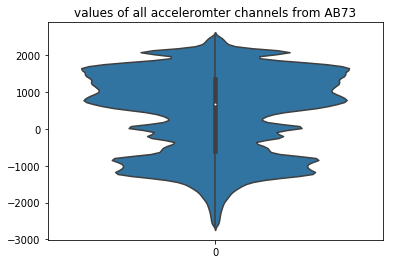

skipping userAE30


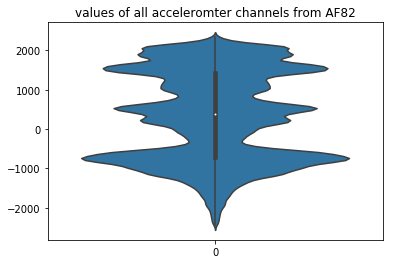

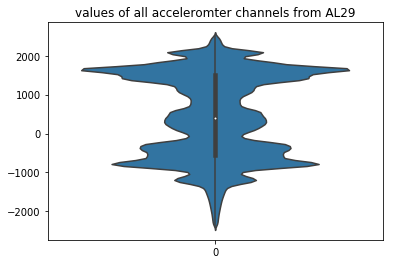

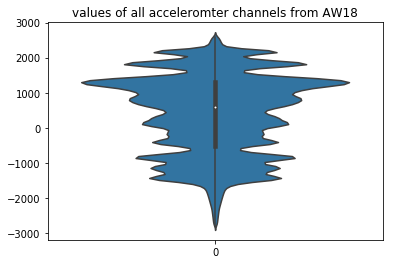

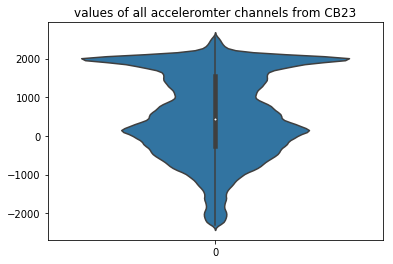

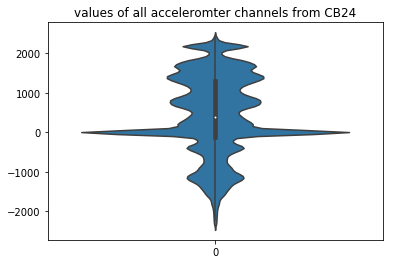

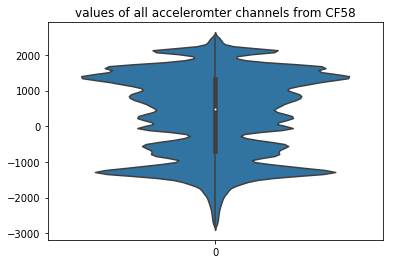

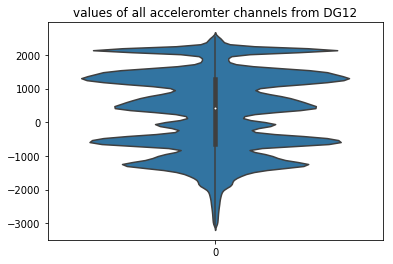

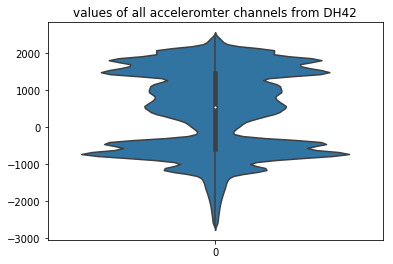

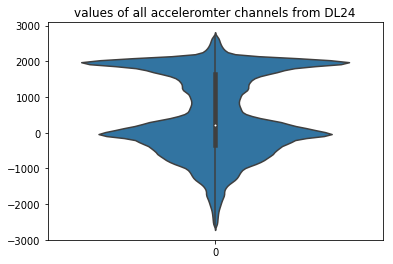

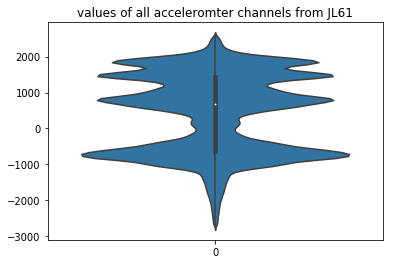

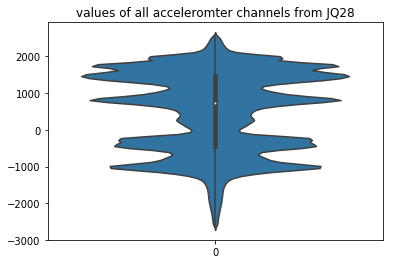

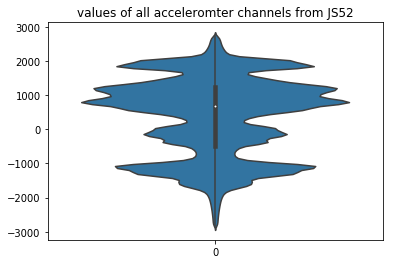

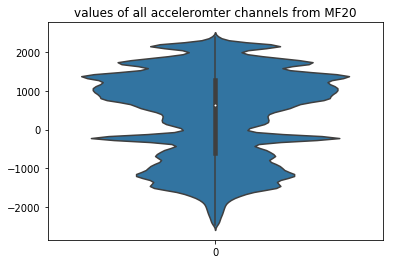

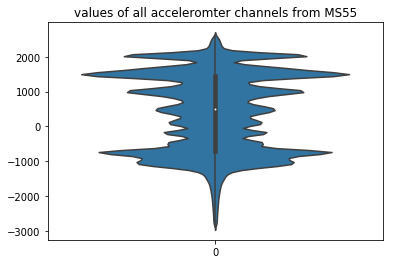

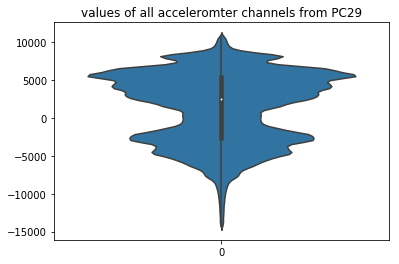

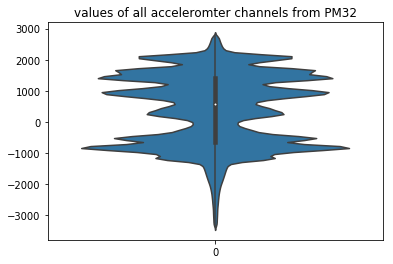

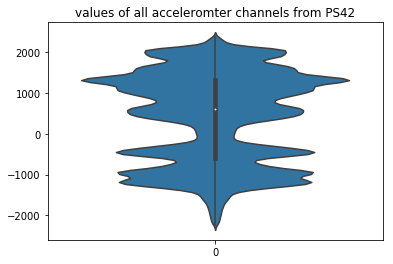

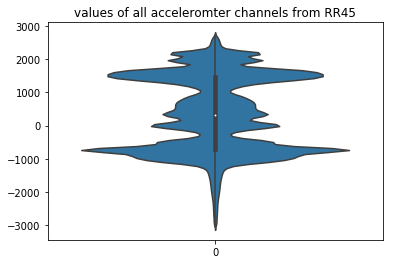

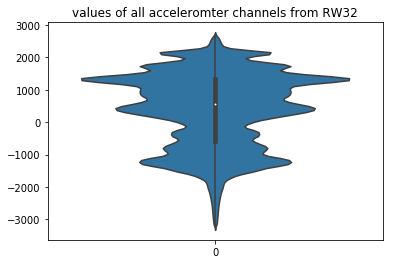

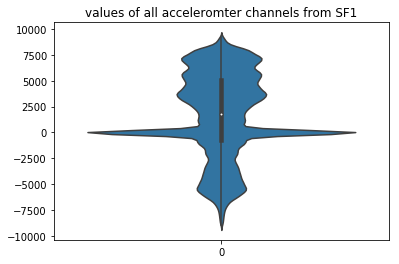

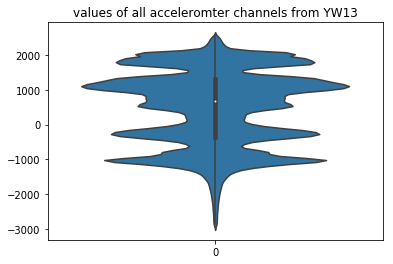

In [365]:
boxplt('acceleromter')

In [454]:
# alternatively we could show it in form of histograms
#ghi.show_valuerange_histograms(usernames, users, cols[all_flex], 
#                               True, higher_percentile, lower_percentile, 
#                               False, False)

skipping userAE30


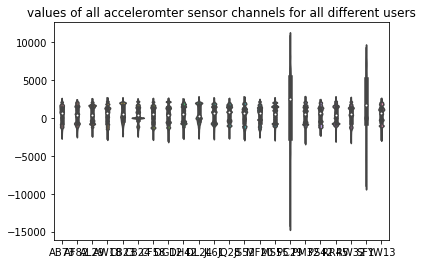

In [375]:
all_distributions_in_one_image('acceleromter')

In [366]:
describe_value_range('gyroscope', True, False)

user:  AB73
                  0
count  3.843168e+06
mean   2.743834e+00
std    1.165744e+03
min   -1.110300e+04
25%   -4.300000e+01
50%    0.000000e+00
75%    3.900000e+01
max    1.135200e+04

skipping userAE30
user:  AF82
                  0
count  2.222535e+06
mean   2.083151e+00
std    1.100658e+03
min   -1.107500e+04
25%   -4.300000e+01
50%   -3.000000e+00
75%    3.100000e+01
max    1.231700e+04

user:  AL29
                  0
count  3.869796e+06
mean  -1.711906e+00
std    1.070078e+03
min   -1.011300e+04
25%   -4.200000e+01
50%   -3.000000e+00
75%    3.000000e+01
max    1.155500e+04

user:  AW18
                  0
count  2.166339e+06
mean   2.078987e-01
std    1.122377e+03
min   -1.192600e+04
25%   -3.700000e+01
50%   -3.000000e+00
75%    3.300000e+01
max    1.459700e+04

user:  CB23
                  0
count  2.211951e+06
mean  -5.747978e+00
std    9.415684e+02
min   -9.273000e+03
25%   -5.300000e+01
50%   -7.000000e+00
75%    4.500000e+01
max    1.043300e+04

user:  CB24
     

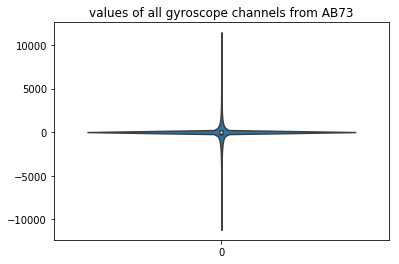

skipping userAE30


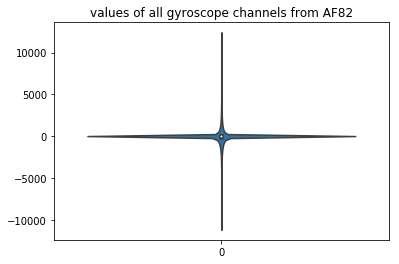

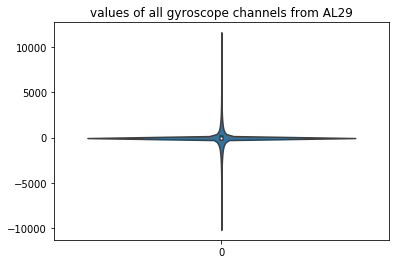

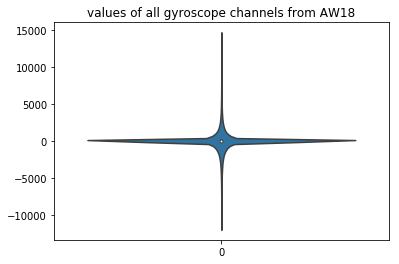

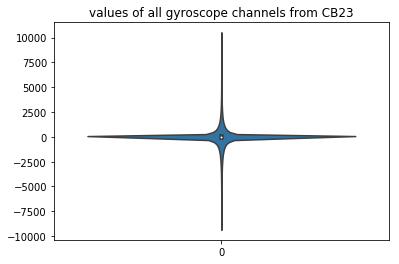

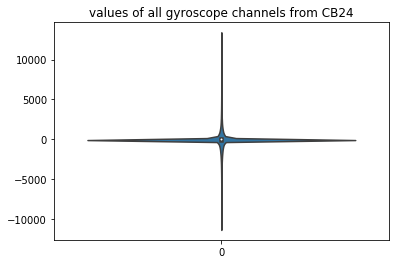

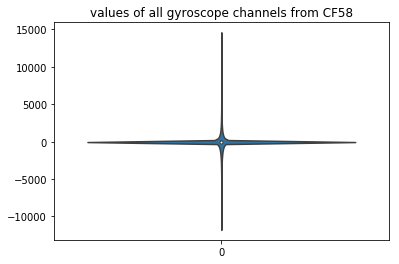

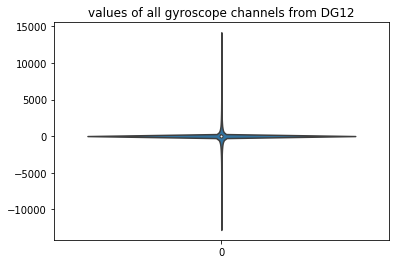

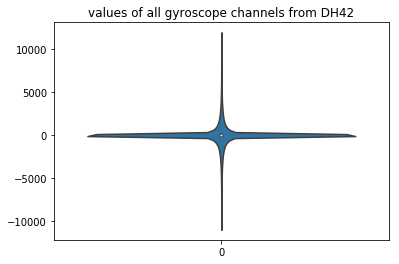

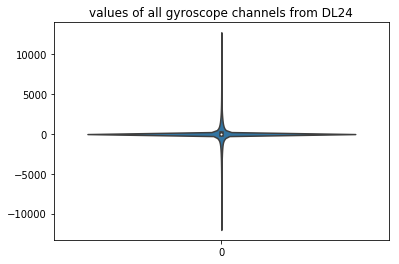

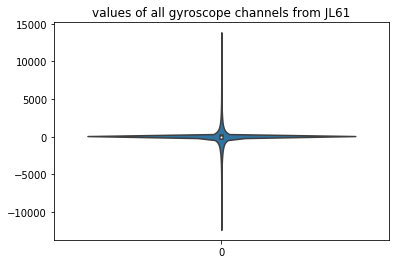

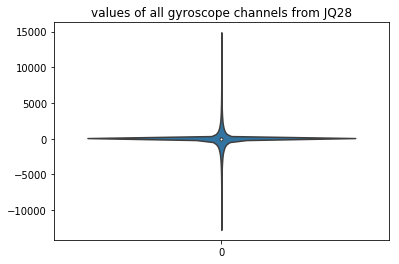

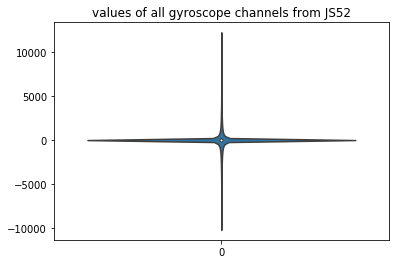

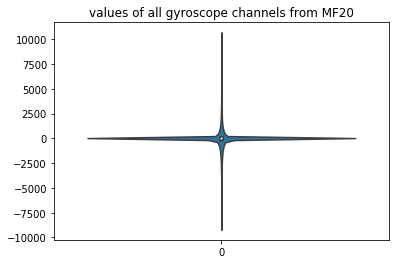

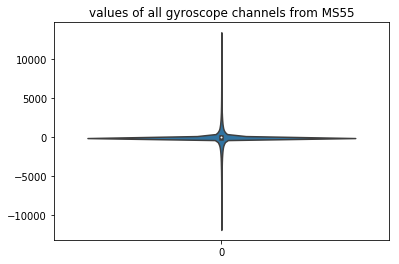

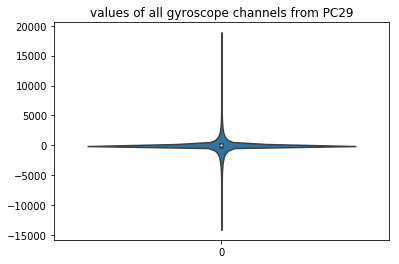

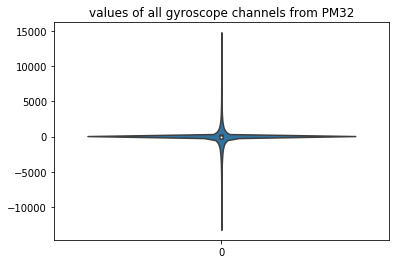

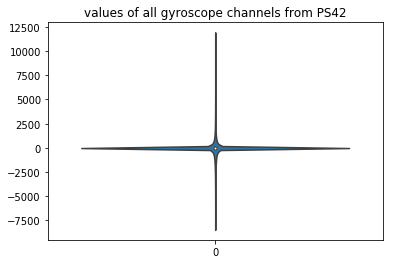

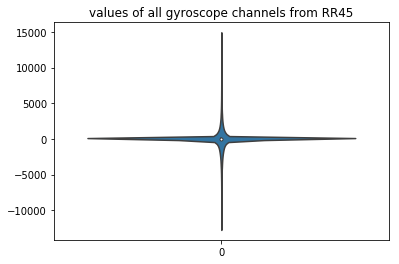

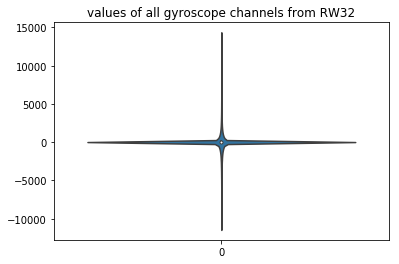

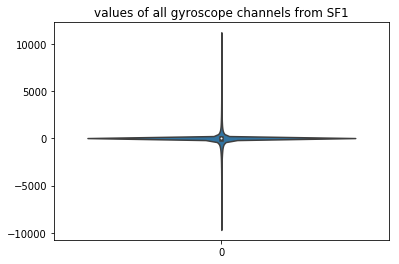

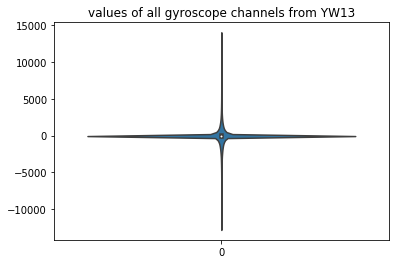

In [368]:
boxplt('gyroscope')

skipping userAE30


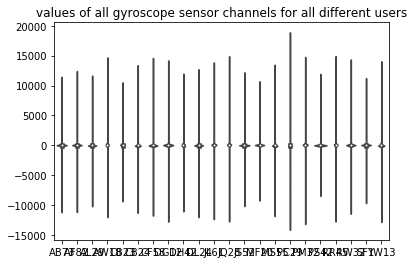

In [376]:
all_distributions_in_one_image('gyroscope')

In [369]:
describe_value_range('flexation', True, False)

user:  AB73
                  0
count  2.379104e+06
mean   1.775108e+03
std    2.945642e+02
min    1.114000e+03
25%    1.623000e+03
50%    1.803000e+03
75%    1.983000e+03
max    2.391000e+03

skipping userAE30
user:  AF82
                  0
count  1.375855e+06
mean   1.758704e+03
std    2.744430e+02
min    1.136000e+03
25%    1.628000e+03
50%    1.759000e+03
75%    1.937000e+03
max    2.354000e+03

user:  AL29
                  0
count  2.395588e+06
mean   1.701076e+03
std    2.628699e+02
min    1.142000e+03
25%    1.592000e+03
50%    1.718000e+03
75%    1.859000e+03
max    2.347000e+03

user:  AW18
                  0
count  1.341067e+06
mean   1.713462e+03
std    3.004126e+02
min    1.075000e+03
25%    1.599000e+03
50%    1.725000e+03
75%    1.916000e+03
max    2.387000e+03

user:  CB23
                  0
count  1.369303e+06
mean   1.752342e+03
std    3.396678e+02
min    1.026000e+03
25%    1.615000e+03
50%    1.804000e+03
75%    2.001000e+03
max    2.342000e+03

user:  CB24
     

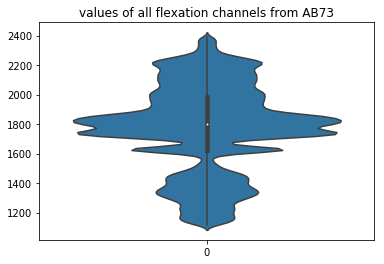

skipping userAE30


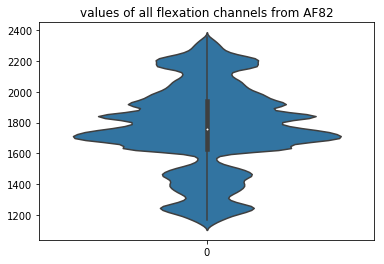

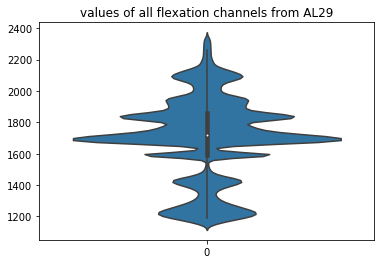

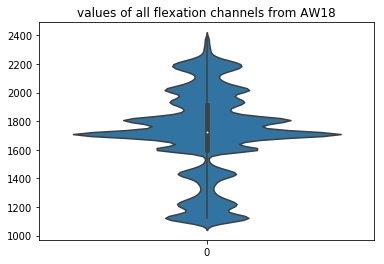

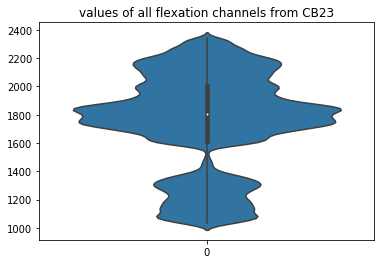

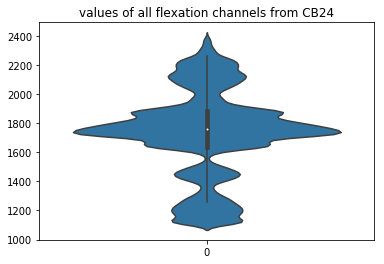

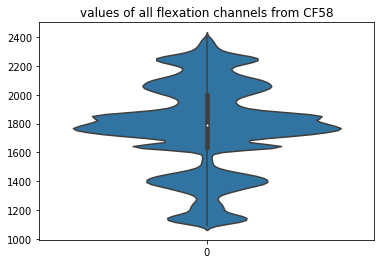

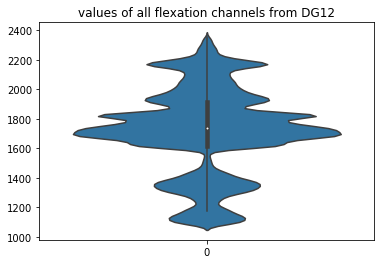

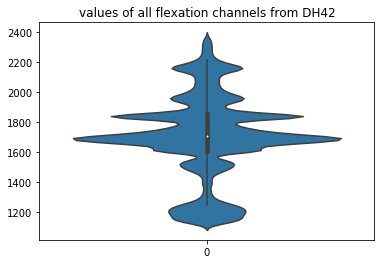

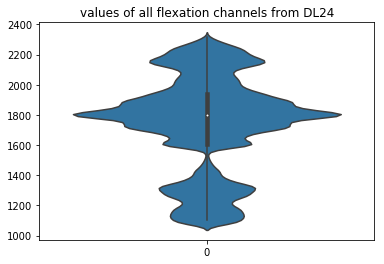

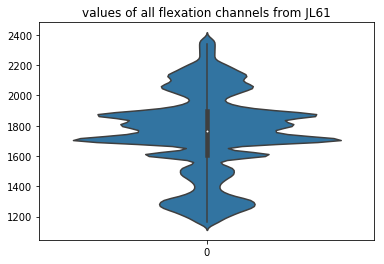

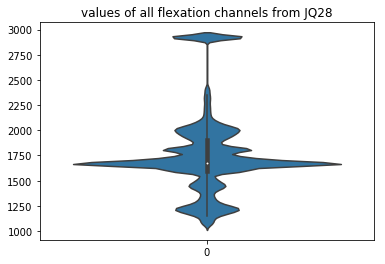

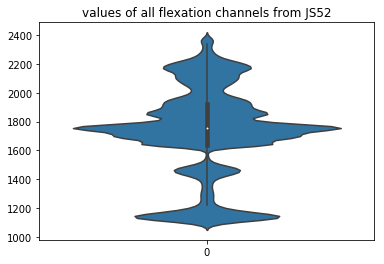

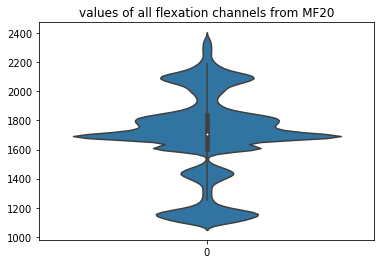

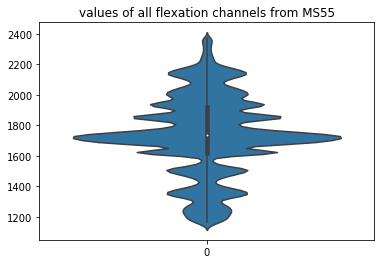

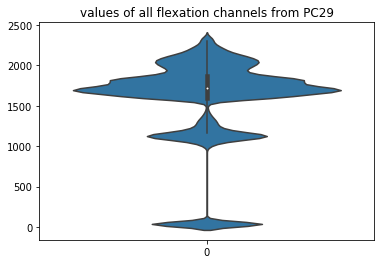

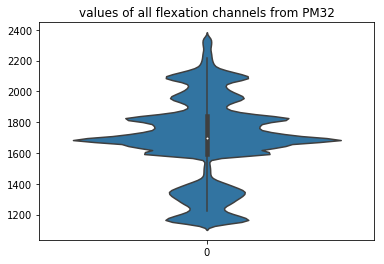

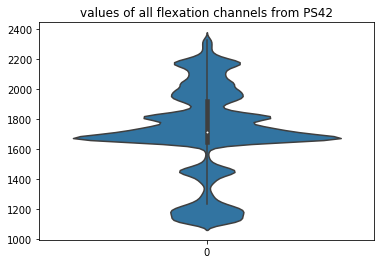

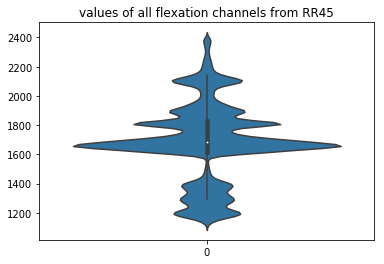

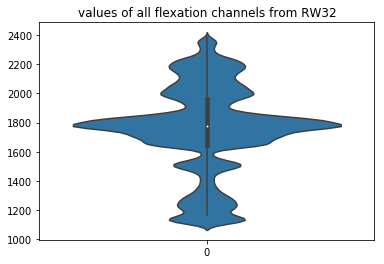

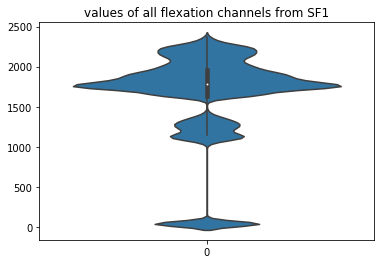

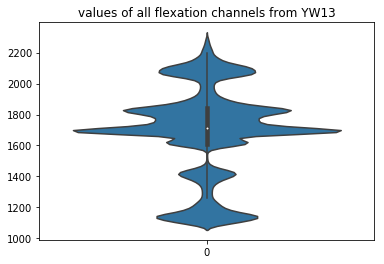

In [370]:
boxplt('flexation')

skipping userAE30


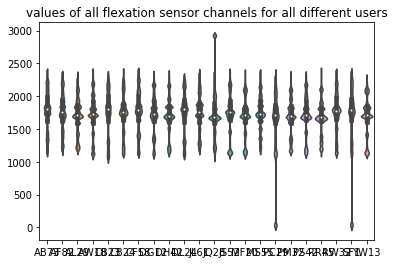

In [377]:
all_distributions_in_one_image('flexation')

In [371]:
describe_value_range('pressure', True, False)

user:  AB73
                   0
count  915040.000000
mean     2871.348066
std       174.980042
min       453.000000
25%      2801.000000
50%      2935.000000
75%      2945.000000
max      2953.000000

skipping userAE30
user:  AF82
                   0
count  529175.000000
mean     2828.987314
std       161.280879
min      1267.000000
25%      2728.000000
50%      2931.000000
75%      2943.000000
max      2952.000000

user:  AL29
                   0
count  921380.000000
mean     2735.135038
std       261.075621
min       706.000000
25%      2557.000000
50%      2844.000000
75%      2941.000000
max      2955.000000

user:  AW18
                   0
count  515795.000000
mean     2811.571522
std       217.549479
min       620.000000
25%      2777.000000
50%      2927.000000
75%      2933.000000
max      2948.000000

user:  CB23
                   0
count  526655.000000
mean     2884.289909
std       186.103517
min       113.000000
25%      2925.000000
50%      2936.000000
75%      2941.0

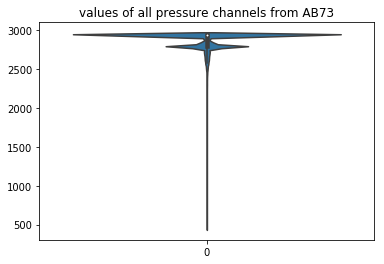

skipping userAE30


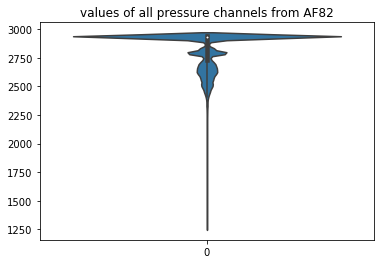

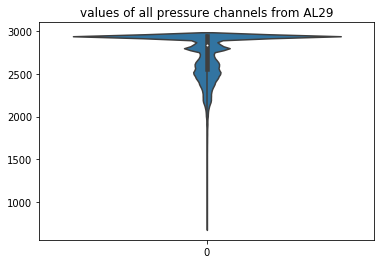

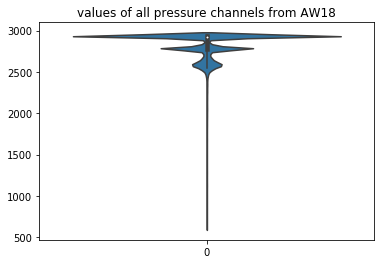

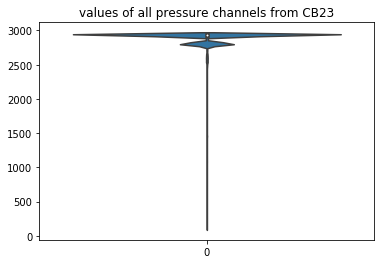

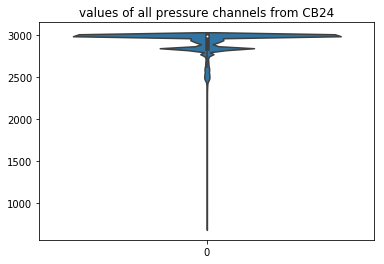

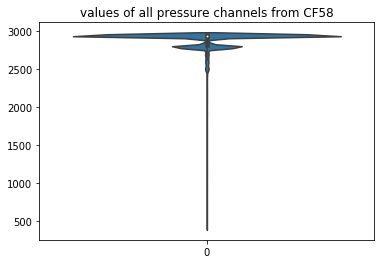

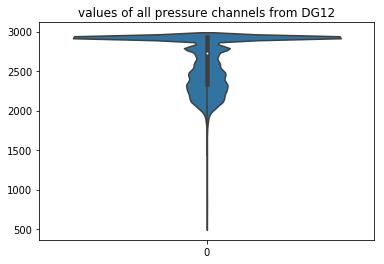

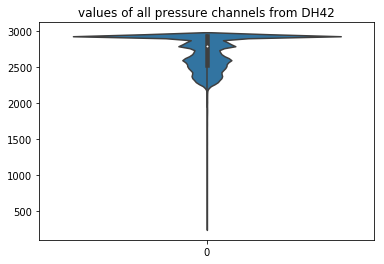

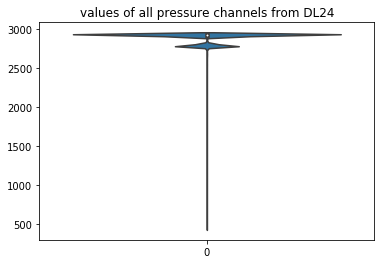

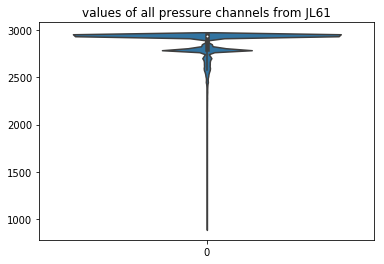

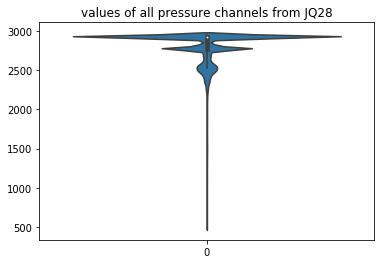

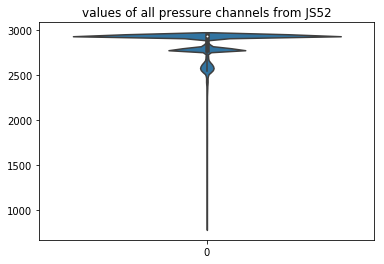

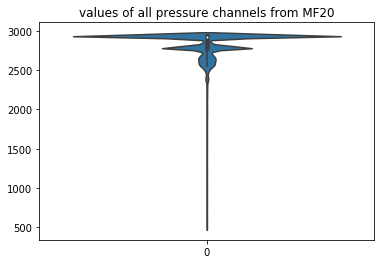

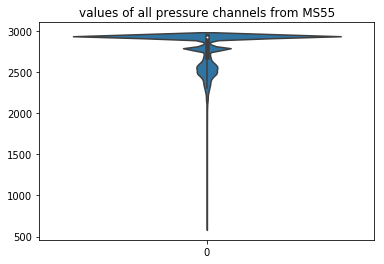

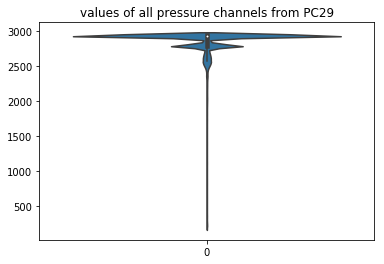

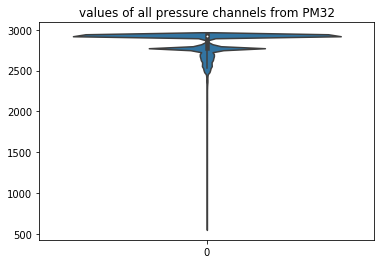

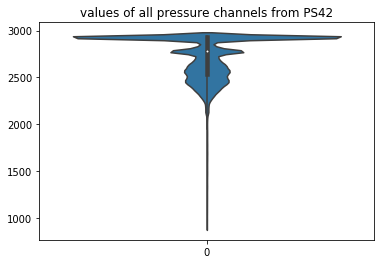

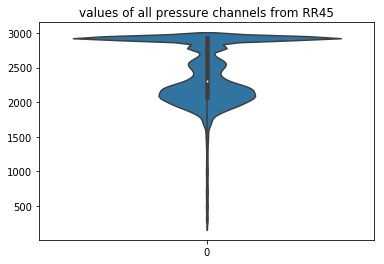

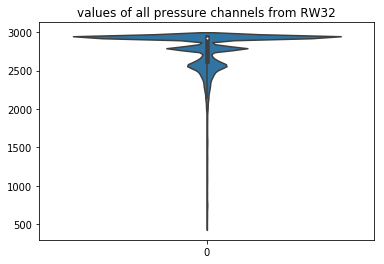

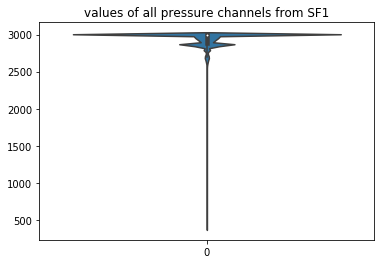

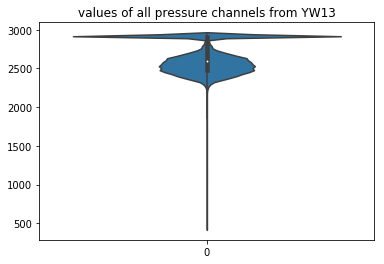

In [372]:
boxplt('pressure')

skipping userAE30


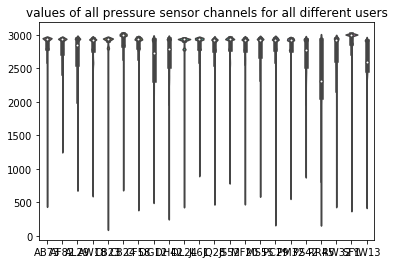

In [378]:
all_distributions_in_one_image('pressure')

## Comparing all Channels

After comparing sensor I want to compare all the channels of the hand. Since we have 63 channels we can not just visually explore the data. Instead we must go to statistical tests. First I each channel if it is normal distributed. This gives us an idea what test we can use for comparison. 

I perform a D’Agostino and Pearson’s test for the values distribution of each user / channel pair. The results are summariezed in the following Table:

We use:
(1, 2) D’Agostino, R. B. (1971), “An omnibus test of normality for moderate and large sample size”, Biometrika, 58, 341-348
[2]	(1, 2) D’Agostino, R. and Pearson, E. S. (1973), “Tests for departure from normality”, Biometrika, 60, 613-622

In [390]:
sensor_names

['acceleromter', 'flexation', 'gyroscope', 'pressure']

In [401]:
def col_to_threshold(c):
    col_list = list(cols)
    sensor_idx = None
    for idx, val in enumerate(all_types):
        if col_list.index(c) in val:
            sensor_idx = idx
            break
    if sensor_idx is None:
        print(c)
    t = thresholds[sensor_idx]
    return t

skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
maybe near nomal? (just out of interest):  14_Finger_3_pressure
DG12 511 2944 104551 948.3484199497701 1.1715400694090994e-206


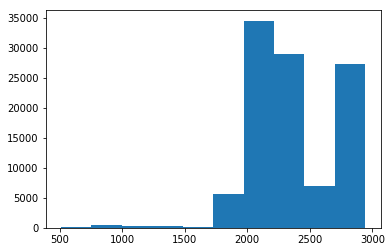

skipping userAE30
skipping userAE30
maybe near nomal? (just out of interest):  16_Wrist_extension
DL24 1088 1577 181278 97.90530452070723 5.497095080435136e-22


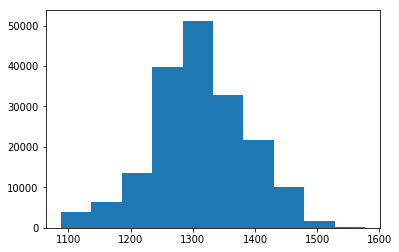

maybe near nomal? (just out of interest):  16_Wrist_extension
SF1 1060 1506 103205 68.82042076440295 1.1371964882345934e-15


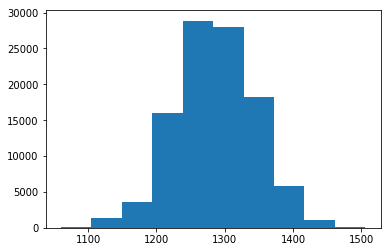

skipping userAE30
maybe near nomal? (just out of interest):  17_Wrist_flexion
SF1 0 83 103205 427.02996392592206 1.8690526261959516e-93


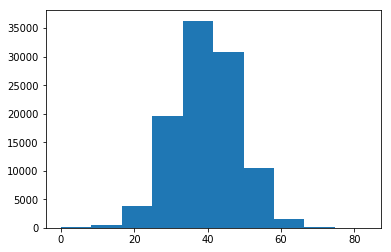

skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30


In [435]:
#print_table_markdown_header()
# test each channel in the data if it is not normal distibuted:

# in this version test data without outlier removal
alpha = 0.0000001
for c in cols[:-7]:
    vals = sutils.values_per_user_for_label_type_and_gesture(
        usernames, users, c, 'manual', 'all_values', False, 
        None, None)
    for v, u in vals:
        vmin, vmax = v.min(), v.max()
        n = len(v)
        k2, p = sp.stats.normaltest(v)
        if p > alpha:
            print('maybe normal: ', c)
            print(u, vmin, vmax, n, k2, p)
            plt.hist(v)
            plt.show()
        elif k2 < 1000.0:
            print('maybe near nomal? (just out of interest): ', c)
            print(u, vmin, vmax, n, k2, p)
            plt.hist(v)
            plt.show()

skipping userAE30
maybe near nomal? (just out of interest):  0_Thumb_base
DG12 1664 1939 104551 604.5800626933183 5.2132367942723456e-132


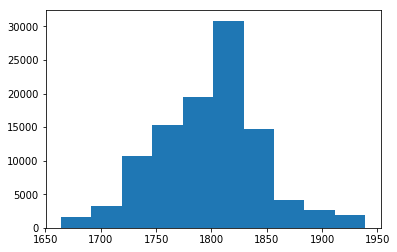

maybe near nomal? (just out of interest):  0_Thumb_base
SF1 1635 1920 103205 499.42396185277494 3.560119849771821e-109


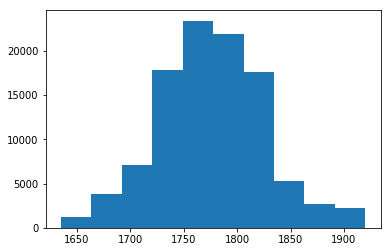

skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
maybe near nomal? (just out of interest):  14_Finger_3_pressure
DG12 646 2941 104551 911.0940300773691 1.4402740012549868e-198


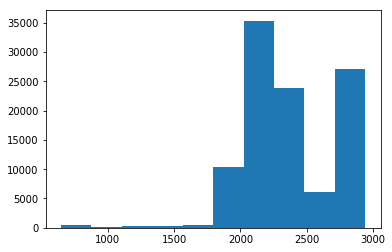

skipping userAE30
skipping userAE30
maybe near nomal? (just out of interest):  16_Wrist_extension
DL24 1115 1502 181278 127.34692343844947 2.223140608366339e-28


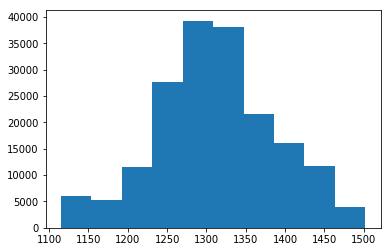

maybe near nomal? (just out of interest):  16_Wrist_extension
SF1 1129 1436 103205 276.1532724539528 1.0816302055724868e-60


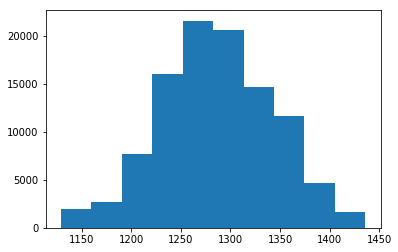

skipping userAE30
maybe near nomal? (just out of interest):  17_Wrist_flexion
AF82 1187 1602 105835 918.1809350204899 4.16431205273909e-200


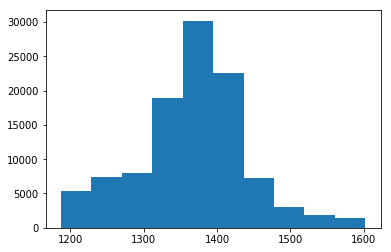

maybe near nomal? (just out of interest):  17_Wrist_flexion
PC29 13 60 120138 86.78285516651025 1.4300210774400288e-19


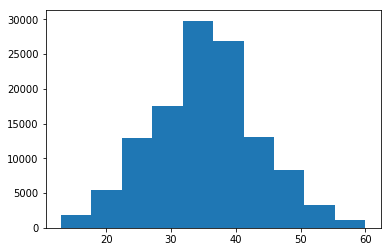

maybe near nomal? (just out of interest):  17_Wrist_flexion
SF1 17 63 103205 91.24476779477357 1.5362094137267725e-20


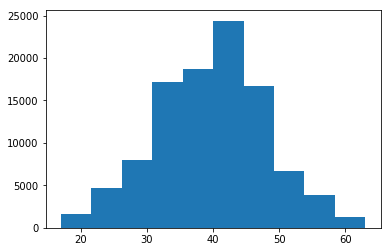

skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30
skipping userAE30


In [434]:
#print_table_markdown_header()
# test each channel in the data if it is not normal distibuted:
alpha = 0.0000001
for c in cols[:-7]:
    lt, ht = col_to_threshold(c)
    vals = sutils.values_per_user_for_label_type_and_gesture(
        usernames, users, c, 'manual', 'all_values', True, 
        ht, lt)
    for v, u in vals:
        vmin, vmax = v.min(), v.max()
        n = len(v)
        k2, p = sp.stats.normaltest(v)
        if p > alpha:
            print('maybe normal: ', c)
            print(u, vmin, vmax, n, k2, p)
            plt.hist(v)
            plt.show()
        elif k2 < 1000.0:
            print('maybe near nomal? (just out of interest): ', c)
            print(u, vmin, vmax, n, k2, p)
            plt.hist(v)
            plt.show()

It is interesting to compare the distributions of the overal data between the zero class and the individual gestures for each sensor. Since we have prooven that these data is not normal distributed we need another means to compare these data. Several options exist: The Kolmogorov–Smirnov test in form of the two-sample K–S test, the Anderson–Darling test as a K-Sample Anderson–Darling test, the Kuiper's test and maybe others. The Kolmogorov–Smirnov is realively well esteblished to make pairwise comparison, which is what I want to do, so we choose this one.

In [437]:
def vpu(c):
    lt, ht = col_to_threshold(c)
    vals = sutils.values_per_user_for_label_type_and_gesture(
        usernames, users, c, 'manual', 'all_values', True, 
        ht, lt)
    return vals

for c1 in cols[:-7]:
    for c2 in cols[:-7]:
        for u in usernames:
            users[u][f'{c1}-{c2}'] = []

for c1 in cols[:-7]:
    for c2 in cols[:-7]:
        print('--------------------------')
        print(f'channel {c1} <-> channel {c2}')
        val1 = vpu(c1)
        val2 = vpu(c2)
        for (v1, u1), (v2, u2) in zip(val1, val2):
            if u1 != u2:
                print('user different?', u1, u2)
                continue
            users[u1][f'{c1}-{c2}'].append(sp.stats.ks_2samp(v1, v2))

--------------------------
channel 0_Thumb_base <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 0_Thumb_base <-> channel 8_Finger_3_tip
skipping userAE30


--------------------------
channel 1_Thumb_pressure <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 1_Thumb_pressure 

--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_hand <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 2_Angle_between_thumb_and_han

--------------------------
channel 3_Finger_1_base <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 3_Finger_1_base <-

--------------------------
channel 4_Finger_1_tip <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 4_Finger_1_tip <-> channe

--------------------------
channel 5_Finger_2_base <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 5_Finger_2_base 

--------------------------
channel 6_Finger_2_tip <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 6_Finger_2_tip <-> channel 47_Thumb_Gyro_

--------------------------
channel 7_Finger_3_base <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 7_Finger_3_base <-> channel 55_Wrist_Accel_Y
sk

--------------------------
channel 8_Finger_3_tip <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 8_Finger_3_tip <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 9_Finger_4_base <-> channel 0_Thumb_base
skip

--------------------------
channel 10_Finger_4_tip <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 10_Finger_4_tip <-> channel 8_Fing

--------------------------
channel 11_Thumb_tip <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 11_Thumb_tip <-> channel 16_Wrist_extension
skipping 

--------------------------
channel 12_Finger_1_pressure <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 12_Finger_1_pressure <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
---------------

--------------------------
channel 13_Finger_2_pressure <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 13_Finger_2_pressure <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
-------------

--------------------------
channel 14_Finger_3_pressure <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 14_Finger_3_pressure <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
------------

--------------------------
channel 15_Finger_4_pressure <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 15_Finger_4_pressure <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
-----------

--------------------------
channel 16_Wrist_extension <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 16_Wrist_extension <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channe

--------------------------
channel 17_Wrist_flexion <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 17_Wrist_flexion <-> channel 50_Pa

--------------------------
channel 18_Finger_1_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Accel_X <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 18_Finger_1_Ac

--------------------------
channel 19_Finger_1_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger_1_Accel_Y <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 19_Finger

--------------------------
channel 20_Finger_1_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 20_Finger_1_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 21_Finger_1_Gyro_X <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
chann

--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finger_1_Gyro_Y <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 22_Finge

--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_1_Gyro_Z <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 23_Finger_

--------------------------
channel 24_Finger_2_Accel_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 24_Finger_2_Accel_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
-----------------

--------------------------
channel 25_Finger_2_Accel_Y <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 25_Finger_2_Accel_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
-------------------

--------------------------
channel 26_Finger_2_Accel_Z <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 26_Finger_2_Accel_Z <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------

--------------------------
channel 27_Finger_2_Gyro_X <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 27_Finger_2_Gyro_X <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
ch

--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 28_Finger_2_Gyro_Y <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
ch

--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_Gyro_Z <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 29_Finger_2_

--------------------------
channel 30_Finger_3_Accel_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Accel_X <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 30_Finger_3_Acc

--------------------------
channel 31_Finger_3_Accel_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 31_Finger_3_A

--------------------------
channel 32_Finger_3_Accel_Z <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 32_Finger_3_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 33_Fi

--------------------------
channel 33_Finger_3_Gyro_X <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 33_Finger_3_Gyro_X <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 34_Finger_3_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 34_Fi

--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 35_Finger_3_Gyro_Z <-> chan

--------------------------
channel 36_Finger_4_Accel_X <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 36_Finger_4_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 37_Finger_4_Accel_Y <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 37_Finger_4_Accel_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
---------------------

--------------------------
channel 38_Finger_4_Accel_Z <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 38_Finger_4_Accel_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------

--------------------------
channel 39_Finger_4_Gyro_X <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 39_Finger_4_Gyro_X <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 40_Finger_4_Gyro_Y <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------


--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 41_Finger_4_Gyro_Z <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 4

--------------------------
channel 42_Thumb_Accel_X <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 42_Thumb_Accel_X <-> channel 51_Pal

--------------------------
channel 43_Thumb_Accel_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 43_Thumb_Accel_Y <-> channel 58_Wrist

--------------------------
channel 44_Thumb_Accel_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 44_Thumb_Accel_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 45_Thumb_Gyro_X <-> channel 2_Angle

--------------------------
channel 46_Thumb_Gyro_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 46_Thumb_Gyro_Y <-> channel 10_Fi

--------------------------
channel 47_Thumb_Gyro_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 47_Thumb_Gyro_Z <-> chan

--------------------------
channel 48_Palm_Accel_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 48_Palm_Accel_X <->

--------------------------
channel 49_Palm_Accel_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 49_Palm_Accel_Y 

--------------------------
channel 50_Palm_Accel_Z <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 50_Palm_Accel_Z 

--------------------------
channel 51_Palm_Gyro_X <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 51_Palm_Gyro_X <-> channel 47_Thumb_Gyro_

--------------------------
channel 52_Palm_Gyro_Y <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 54_Wrist_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 52_Palm_Gyro_Y <-> channel 55_Wrist_Accel_Y
skipping us

--------------------------
channel 53_Palm_Gyro_Z <-> channel 55_Wrist_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 56_Wrist_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 57_Wrist_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 58_Wrist_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 59_Wrist_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 60_Magnetometer_X
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 61_Magnetometer_Y
skipping userAE30
skipping userAE30
--------------------------
channel 53_Palm_Gyro_Z <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 54_Wrist_Accel_X <-> channel 0_Thumb_base
ski

--------------------------
channel 54_Wrist_Accel_X <-> channel 62_Magnetometer_Z
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 0_Thumb_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 1_Thumb_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 2_Angle_between_thumb_and_hand
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 3_Finger_1_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 4_Finger_1_tip
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 5_Finger_2_base
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 55_Wrist_Accel_Y <-> cha

--------------------------
channel 56_Wrist_Accel_Z <-> channel 6_Finger_2_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 7_Finger_3_base
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 8_Finger_3_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 9_Finger_4_base
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 10_Finger_4_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 11_Thumb_tip
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 12_Finger_1_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 56_Wrist_Accel_Z <-> channel 14_

--------------------------
channel 57_Wrist_Gyro_X <-> channel 13_Finger_2_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 14_Finger_3_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 15_Finger_4_pressure
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 16_Wrist_extension
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 17_Wrist_flexion
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 18_Finger_1_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 19_Finger_1_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_X <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 57_Wrist_Gyro_

--------------------------
channel 58_Wrist_Gyro_Y <-> channel 20_Finger_1_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 21_Finger_1_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 22_Finger_1_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 23_Finger_1_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 24_Finger_2_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 25_Finger_2_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 26_Finger_2_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 58_Wrist_Gyro_Y <

--------------------------
channel 59_Wrist_Gyro_Z <-> channel 27_Finger_2_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 28_Finger_2_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 29_Finger_2_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 30_Finger_3_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 31_Finger_3_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 32_Finger_3_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 33_Finger_3_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 59_Wrist_Gyro_Z <-

--------------------------
channel 60_Magnetometer_X <-> channel 34_Finger_3_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 35_Finger_3_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 36_Finger_4_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 37_Finger_4_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 38_Finger_4_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 39_Finger_4_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 60_Magnetometer_X <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 60

--------------------------
channel 61_Magnetometer_Y <-> channel 40_Finger_4_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 41_Finger_4_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 42_Thumb_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 43_Thumb_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 44_Thumb_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 45_Thumb_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 61_Magnetometer_Y <-

--------------------------
channel 62_Magnetometer_Z <-> channel 46_Thumb_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 47_Thumb_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 48_Palm_Accel_X
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 49_Palm_Accel_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 50_Palm_Accel_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 51_Palm_Gyro_X
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 52_Palm_Gyro_Y
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 53_Palm_Gyro_Z
skipping userAE30
skipping userAE30
--------------------------
channel 62_Magnetometer_Z <-> channel 54

In [438]:
# in case the script above worked, execute that line:
with open( stats_added_path_pickl, "wb" ) as users_pickle_file:
    pickle.dump(users, users_pickle_file)

In [ ]:
# in case you need to reload, and know it exists:
with open( stats_added_path_pickl, "rb" ) as users_pickle_file:
    users = pickle.load(users_pickle_file)

Since we computed the k-s statistic of each channel to each other we can display a heatmap with this data so show how different the channel distributions are avaraged over all users. A value of 0 means they are the same, a value of 1 means they are totally different. Since we compare value ranges with hundred thousands of values all differences come up as highly significant, so we obmit p-values (all are below 0.0e-15).

In [439]:
matrix = np.zeros((len(cols[:-7]), len(cols[:-7])))

for u in usernames:
    if not 'glove_merged' in users[u]:
        print('skipping user' + u)
        continue
    for c1 in cols[:-7]:
        idx_1 = cols.get_loc(c1)
        for c2 in cols[:-7]:
            idx_2 = cols.get_loc(c2)
            stats = users[u][f'{c1}-{c2}'][0]
            matrix[idx_1, idx_2] += stats[0]
matrix = matrix / (len(usernames)-1.)

skipping userAE30


In [440]:
matrix

array([[0.        , 0.98849071, 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.98849071, 0.        , 0.99243474, ..., 0.99801037, 0.99958163,
        0.99899221],
       [1.        , 0.99243474, 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 0.99801037, 1.        , ..., 0.        , 0.79214348,
        0.63473187],
       [1.        , 0.99958163, 1.        , ..., 0.79214348, 0.        ,
        0.77350022],
       [1.        , 0.99899221, 1.        , ..., 0.63473187, 0.77350022,
        0.        ]])

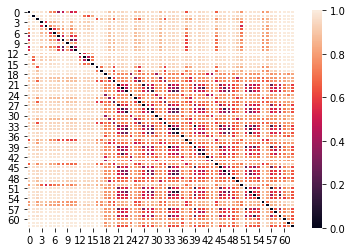

In [441]:
import seaborn as sns
ax = sns.heatmap(matrix, linewidth=0.5)#, xticklabels=cols[:-7], yticklabels=cols[:-7])
#ax.set_xticks(np.arange(len(cols[:-7])))
#ax.set_yticks(np.arange(len(cols[:-7])))
#ax.set_xticklabels(cols[:-7])
#ax.set_yticklabels(cols[:-7])
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#         rotation_mode="anchor")
plt.show()

In [442]:
# let's find the most uniform user and the most non-uniform user:
result = {}
for u in usernames:
    if not 'glove_merged' in users[u]:
        print('skipping user' + u)
        continue
    result[u] = 0.0
    for c1 in cols[:-7]:
        idx_1 = cols.get_loc(c1)
        for c2 in cols[:-7]:
            idx_2 = cols.get_loc(c2)
            stats = users[u][f'{c1}-{c2}'][0]
            result[u] += stats[0]
ordered_keys = sorted(result, key=result.get)

skipping userAE30


CB23


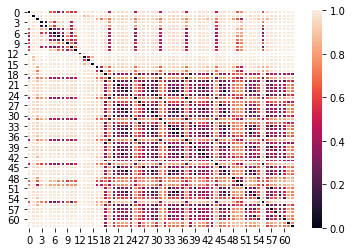

In [443]:
u = ordered_keys[0]
print(u)
matrix_u = np.zeros((len(cols[:-7]), len(cols[:-7])))
for c1 in cols[:-7]:
    idx_1 = cols.get_loc(c1)
    for c2 in cols[:-7]:
        idx_2 = cols.get_loc(c2)
        stats = users[u][f'{c1}-{c2}'][0]
        matrix_u[idx_1, idx_2] += stats[0]
ax = sns.heatmap(matrix_u, linewidth=0.5)
plt.show()

MS55


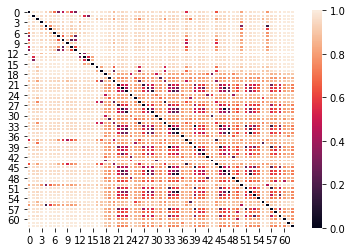

In [444]:
u = ordered_keys[-1]
print(u)
matrix_u = np.zeros((len(cols[:-7]), len(cols[:-7])))
for c1 in cols[:-7]:
    idx_1 = cols.get_loc(c1)
    for c2 in cols[:-7]:
        idx_2 = cols.get_loc(c2)
        stats = users[u][f'{c1}-{c2}'][0]
        matrix_u[idx_1, idx_2] += stats[0]
ax = sns.heatmap(matrix_u, linewidth=0.5)
plt.show()

In [445]:
def val_(username: str, columes, label_type: str, gesture: str):
    lt, ht = col_to_threshold(columes)
    return sutils.values_for_user_for_label_type_and_gesture(
        username, users, columes, label_type, gesture, True, 
        ht, lt)

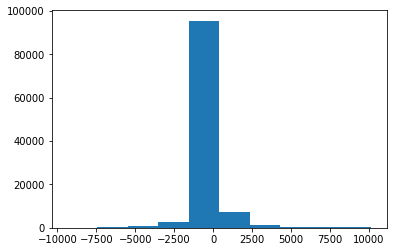

In [446]:
# according to that values of channel 21 and 22 are very similar 
# (I guess they are x,y form acceleromter) but f.e. 10. 10 again is similar to 11.
# let's check that for user MS55:
vals = val_('MS55', cols[21], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

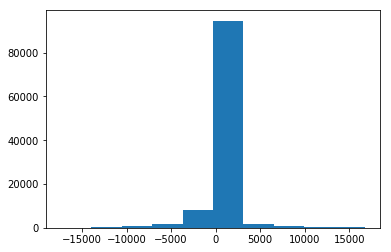

In [447]:
vals = val_('MS55', cols[22], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

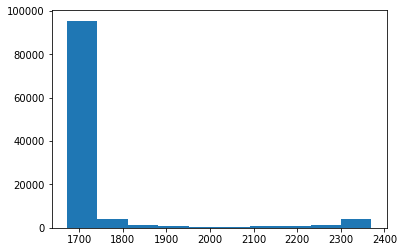

In [448]:
vals = val_('MS55', cols[10], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

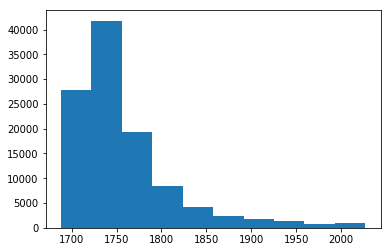

In [449]:
vals = val_('MS55', cols[11], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

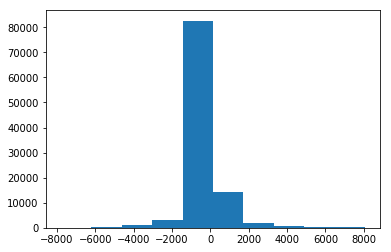

In [450]:
vals = val_('CB23', cols[21], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

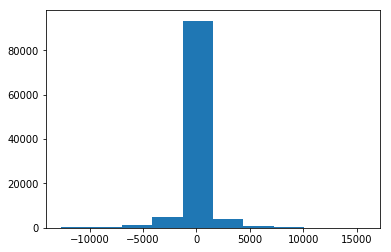

In [451]:
vals = val_('CB23', cols[22], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

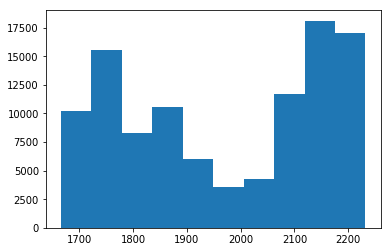

In [452]:
vals = val_('CB23', cols[10], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

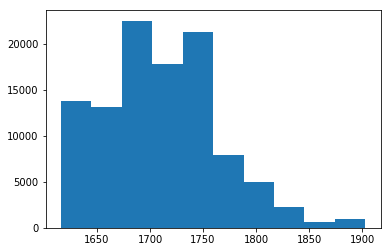

In [453]:
vals = val_('CB23', cols[11], None, 'all_values')
plt.hist(vals)
plt.show()
plt.close()

## Distribution when doing a gesture vs. not doing a gesture

bla bla

In [460]:
def show_valuerange_in_our_outside_labels(sensor_name, inside_or_outside):
    sensor_idx = sensor_names.index(sensor_name)
    cs = cols[all_types[sensor_idx]]
    t = thresholds[sensor_idx]
    lower_percentile, higher_percentile = t
    if inside_or_outside == 'zero_class':
        title = f'all values outside manual label for {sensor_name}'
    else:
        title = f'all values within any manual label for {sensor_name}'
    gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
        usernames, users, title, cs, 'label_manual', inside_or_outside, 
        True, ht, lt, False, False)
    

skipping userAE30


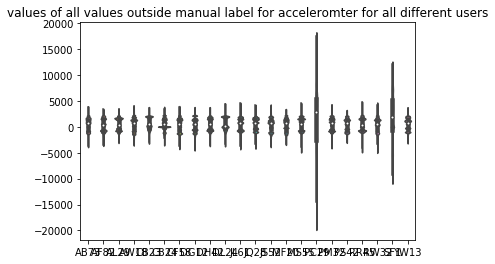

In [461]:
show_valuerange_in_our_outside_labels('acceleromter', 'zero_class')

skipping userAE30


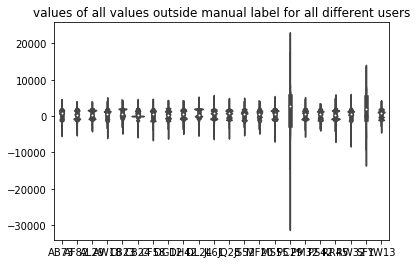

In [455]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values outside manual label', cols[all_accel], 
    'label_manual', 'zero_class', True, higher_percentile, lower_percentile, False, False)

skipping userAE30


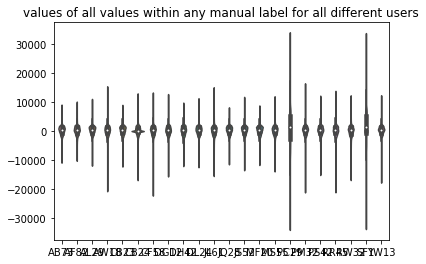

In [456]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values within any manual label', cols[all_accel], 
    'label_manual', 'all_labels', True, higher_percentile, lower_percentile, False, False)
#show_boxplots_row_lc(cols[all_accel], 'label_manual', 'all_labels', True, False)

In [ ]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values outside manual label', cols[all_gyro], 
    'label_manual', 'zero_class', True, higher_percentile, lower_percentile, False, False)

In [ ]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values within any manual label', cols[all_gyro], 
    'label_manual', 'all_labels', True, higher_percentile, lower_percentile, False, False)

In [ ]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values outside manual label', cols[all_flex], 
    'label_manual', 'zero_class', True, higher_percentile, lower_percentile, False, False)

In [ ]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values within any manual label', cols[all_flex], 
    'label_manual', 'all_labels', True, higher_percentile, lower_percentile, False, False)

In [ ]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values outside manual label', cols[all_pressure], 
    'label_manual', 'zero_class', True, higher_percentile, lower_percentile, False, False)

In [ ]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values within manual label', cols[all_pressure], 
    'label_manual', 'all_labels', True, higher_percentile, lower_percentile, False, False)

In [ ]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values outside manual label', cols[all_magnetometer], 
    'label_manual', 'zero_class', True, higher_percentile, lower_percentile, False, False)

In [ ]:
gbo.show_valuerange_boxplots_in_one_imagefor_label_type_and_gesture(
    usernames, users, 'all values within any manual label', cols[all_magnetometer], 
    'label_manual', 'all_labels', True, higher_percentile, lower_percentile, False, False)